In [1]:
import numpy as np
from collections import deque
from math import inf
import matplotlib.pyplot as plt

In [2]:
def generate_matrix(k):
    n = 2 ** (3 * k)
    
    matrix = np.zeros((n, n))
    
    row_length = 2 ** k
    neighbours = [-1, 1, row_length, -row_length, row_length ** 2, -(row_length ** 2)]
    
    for i in range(n):
        for neigh in neighbours:
            neight_id = i + neigh
            matrix[i, i] = 1
            if neight_id < 0 or neight_id >= n: 
                continue
                
            # Same row
            if neight_id // row_length == i // row_length:
                matrix[i, neight_id] = 1
            
            # Same column
            elif neight_id % row_length == i % row_length:
                matrix[i, neight_id] = 1
            
            # Same in third dimension
            else:
                matrix[i, neight_id] = 1
    

    return matrix

In [3]:
def graph(matrix):
    n = len(matrix)
    V = {}
    for i in range(n):
        V[i] = set()
        for j in range(n):
            if matrix[i, j] != 0:
                V[i].add(j)
    return V

def minimum_degree(matrix):
    # Create graph
    n = len(matrix)
    V = graph(matrix)
    pq = set([v for v in V.keys()])
    
    permutation = []
    
    for i in range(n):
        min_v, min_degree = None, inf
        
        for v in pq:
            if len(V[v]) < min_degree:
                min_degree = len(V[v])
                min_v = v
        
        permutation.append(min_v)
        
        pq.remove(min_v)
        
        for u in V:
            V[u].discard(min_v)
        
        for u in V[min_v]:
            V[u] = (V[u].union(V[min_v])).difference(set([u, min_v]))
    
    return permutation  

In [4]:
def cuthill_mckee(matrix):
    def BFS():
        while queue:
            v = queue.popleft()
            
            if visited[v]: continue
            
            visited[v] = True
            permutation.append(v)
            for u in sorted(G[v], key=lambda x: len(G[x])):
                if not visited[u]:
                    queue.append(u)
            
        
    
    n = len(matrix)
    G = graph(matrix) # No need to sort because I use heapque
    
    visited = [False for _ in range(n)]
    queue = deque()
    sorted_nodes = sorted([(len(edges), v) for v, edges in G.items()], key=lambda x: x[0])
    
    permutation = []
    for prior, node in sorted_nodes:
        if not visited[node]:
            queue.append(node)
            BFS()
    return permutation
    
    

In [5]:
def reversed_cuthill_mckee(matrix):
    return list(reversed(cuthill_mckee(matrix)))

In [6]:
def permutate(matrix, p_table):
    copied = matrix.copy()
    new_matrix = copied[p_table, :]
    return new_matrix[:, p_table]

In [7]:
def meassure_compression(matrix, compressed_matrix):
    def travel(node):
        if node.U is None and node.V is None and node.rank == 0: # Only zeros
            return 0

        elif node.children is None: # Leaf
            if node.val is not None: # Leaf

                return 1
            else:
                U_shape = node.U.shape
                V_shape = node.V.shape
                
                s = len(node.s)
                return U_shape[0] * U_shape[1] + s + V_shape[0] * V_shape[1]
        else:
            childs = node.children
            res = 0
            for child in childs:
                res += travel(child)
            return res
        
    shape = matrix.shape
    elements = shape[0] * shape[1]
    return travel(compressed_matrix) / elements

### z lab 3

In [8]:
import numpy as np
import scipy.sparse as sp
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt

class CompressNode:
    def __init__(self, rank=0, children=None, singular_values=None, U=None, V=None, size=None):
        self.rank = rank
        self.children = children
        self.s = singular_values
        self.U = U
        self.V = V
        self.size = size
        self.val = None
        
    def append_child(self, child):
        self.children.append(child)
    
    def __str__(self):
        return f'Node: rank = {self.rank}; children: {self.children}; s: {self.s}; U = {self.U}; V = {self.V}, size = {self.size}'
    

def compress_matrix(matrix, U, s, V, r):
    node = None
    if (matrix == 0).all():
        node = CompressNode(rank=0, size=matrix.shape)
    
    else:
        D = np.diag(s)
        node = CompressNode(rank=r, singular_values=s, U=U, V=D @ V, 
                            size=matrix.shape)
    
    return node

def create_tree(matrix, r, epsilon):
    U, s, V = randomized_svd(matrix, n_components=r)
    rank = s.size
    node = None
    if s[-1] < epsilon:
        node = compress_matrix(matrix, U, s, V, rank)
    
    else:
        Y, X = matrix.shape
        
        if Y == X == 1:
            node = CompressNode(rank=1, size=(1, 1))
            node.val = matrix
            return node
        
        node = CompressNode(rank=r, children=[], size=(Y, X))
        
        # 4 childrens
        
        node.append_child(create_tree(matrix[0: Y // 2, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[0: Y // 2, X // 2: X], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, X // 2: X], r, epsilon))
        
    return node


def _canvas_matrix(wisualized, root, x, y, n): #n must be 2^i where i is natural number
    
    
    if root.U is None and root.V is None and root.rank == 0: # Only zeros
        return
    
    elif root.children is None: # Leaf
        if root.val is not None: # Leaf
            wisualized[y, x] = 128 # Gray
            return
        else:
            xe = x + root.size[1]
            ye = y + root.size[0]

            wisualized[y: y + root.rank, x: xe] = np.ones((root.rank, xe - x)) * 64  # Horizontal
            wisualized[y: ye, x: x + root.rank] = np.ones((ye - y, root.rank)) * 64  # Vertical
            
            return
    
    else:
        childs = root.children
        n = n//2
        _canvas_matrix(wisualized, childs[0], x, y, n)
        _canvas_matrix(wisualized, childs[1], x + n, y, n)
        _canvas_matrix(wisualized, childs[2], x, y + n, n)
        _canvas_matrix(wisualized, childs[3], x + n, y + n, n)
        return

def wisualize_svd(matrix_tree: CompressNode, n):
    wisualized = np.ones((n, n)) * 255
    _canvas_matrix(wisualized, matrix_tree, 0, 0, n)
    plt.imshow(wisualized, 'gray')

## Raport
K = 2

In [9]:
k = 2
matrix = generate_matrix(k)

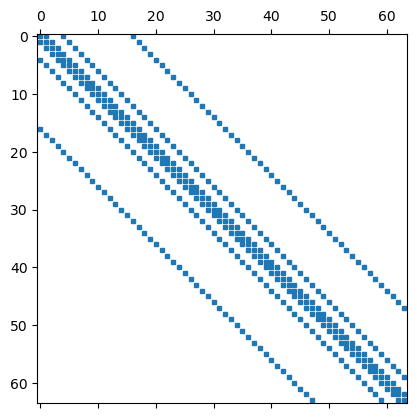

In [10]:
plt.spy(matrix, markersize=3)
# plt.title("Wzorzec rzadkości przed kompresją i permutacją")
plt.show()

0.3350


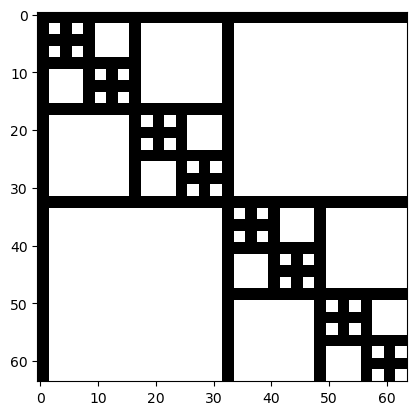

In [11]:
n = len(matrix)
U, s, V = np.linalg.svd(matrix)
tree = create_tree(matrix, 2, s[len(s) // 2])
print(f'{meassure_compression(matrix, tree):.4f}')
wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości przed permutacją po kompresji")

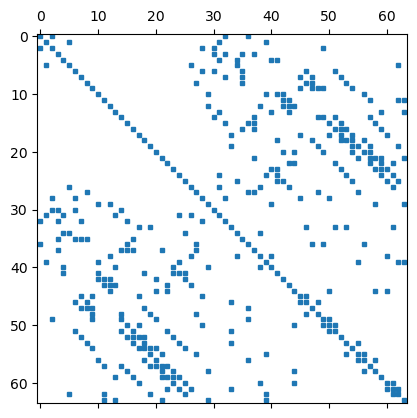

In [12]:
p_table = minimum_degree(matrix)
permutate_matrix_md = permutate(matrix, p_table)
plt.spy(permutate_matrix_md, markersize=3)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"minimum degree\"")
plt.show()

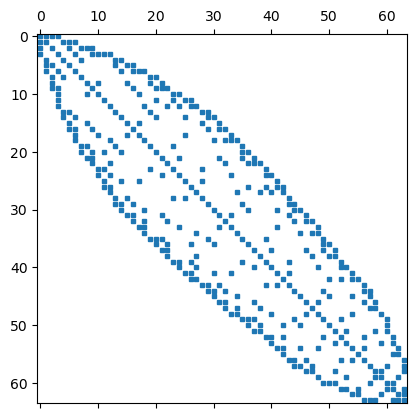

In [13]:
p_table = cuthill_mckee(matrix)
permutate_matrix_cmk = permutate(matrix, p_table)

plt.spy(permutate_matrix_cmk, markersize=3)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"Cuthill-McKee\"")
plt.show()

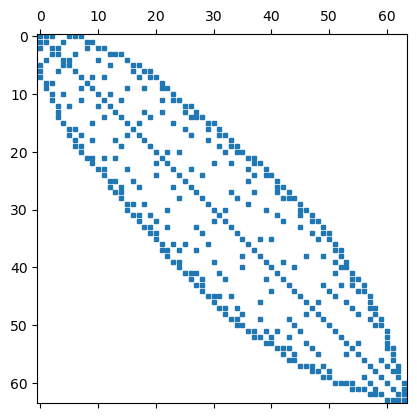

In [14]:
p_table = reversed_cuthill_mckee(matrix)
permutate_matrix_rcmk = permutate(matrix, p_table)

plt.spy(permutate_matrix_rcmk, markersize=3)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"reversed Cuthill-McKee\"")
plt.show()

0.4580078125


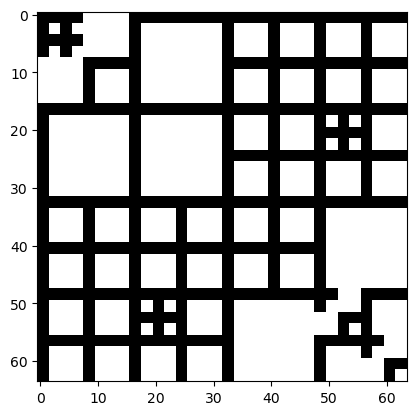

In [15]:
n = len(matrix)
tree = create_tree(permutate_matrix_md, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))

wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"minimum degree\" i po kompresji")
plt.show()

0.31982421875


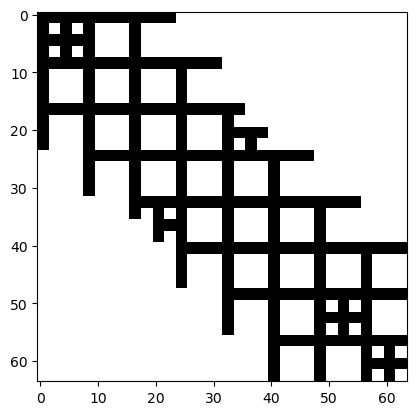

In [16]:
n = len(matrix)
tree = create_tree(permutate_matrix_cmk, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))

wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"Cuthill-McKee\" i po kompresji")
plt.show()

0.31982421875


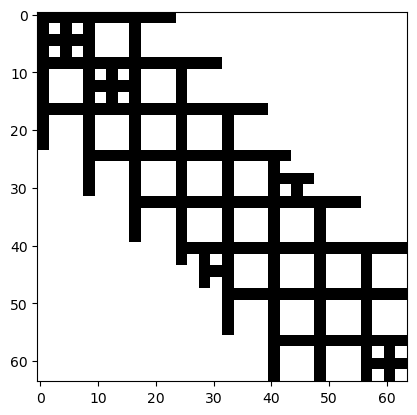

In [17]:
n = len(matrix)
tree = create_tree(permutate_matrix_rcmk, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))

wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"reversed Cuthill-McKee\" i po kompresji")
plt.show()

K = 3

In [18]:
k = 3
matrix = generate_matrix(k)

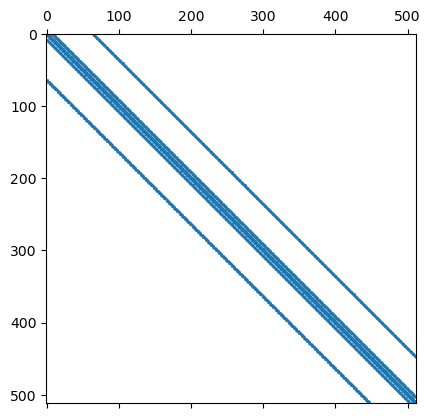

In [19]:
plt.spy(matrix, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją i permutacją")
plt.show()

0.0654144287109375


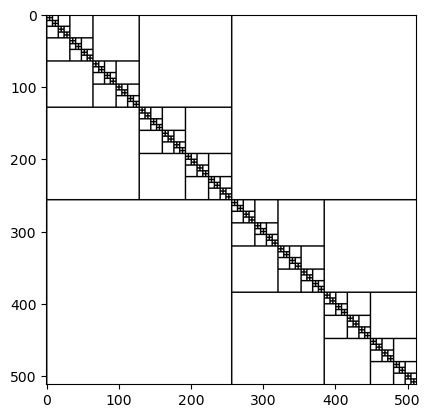

In [20]:
n = len(matrix)
U, s, V = np.linalg.svd(matrix)
tree = create_tree(matrix, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))


wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości przed permutacją po kompresji")

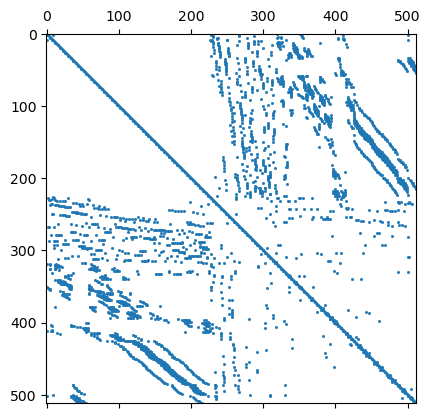

In [21]:
p_table = minimum_degree(matrix)
permutate_matrix_md = permutate(matrix, p_table)
plt.spy(permutate_matrix_md, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"minimum degree\"")
plt.show()

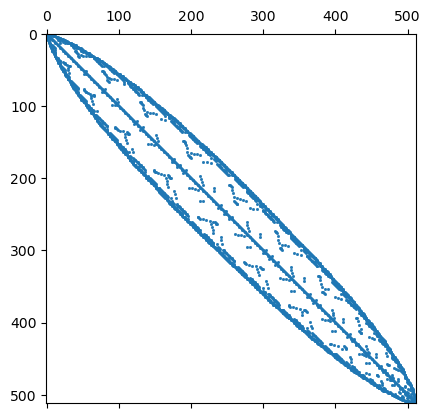

In [22]:
p_table = cuthill_mckee(matrix)
permutate_matrix_cmk = permutate(matrix, p_table)

plt.spy(permutate_matrix_cmk, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"Cuthill-McKee\"")
plt.show()

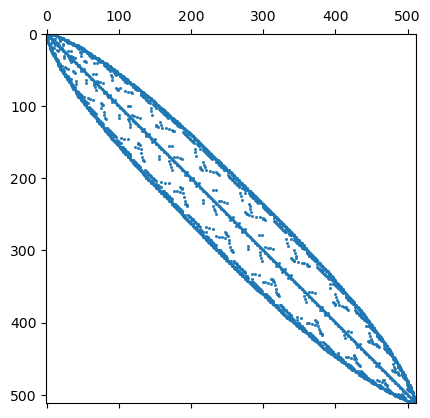

In [23]:
p_table = reversed_cuthill_mckee(matrix)
permutate_matrix_rcmk = permutate(matrix, p_table)

plt.spy(permutate_matrix_rcmk, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"reversed Cuthill-McKee\"")
plt.show()

0.1253814697265625


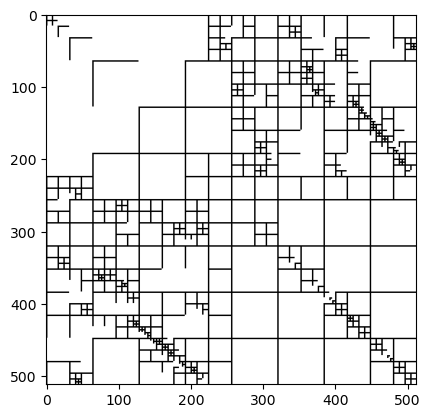

In [24]:
n = len(matrix)
tree = create_tree(permutate_matrix_md, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))

wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"minimum degree\" i po kompresji")
plt.show()

0.07743072509765625


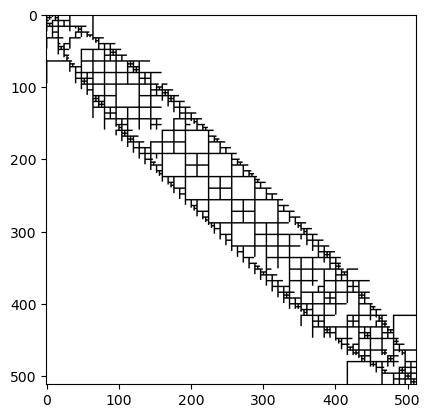

In [25]:
n = len(matrix)
tree = create_tree(permutate_matrix_cmk, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))


wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"Cuthill-McKee\" i po kompresji")
plt.show()

0.07743072509765625


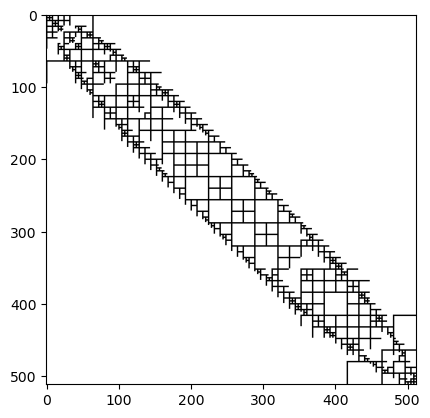

In [26]:
n = len(matrix)
tree = create_tree(permutate_matrix_rcmk, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))


wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"reversed Cuthill-McKee\" i po kompresji")
plt.show()

K = 4

In [27]:
k = 4
matrix = generate_matrix(k)

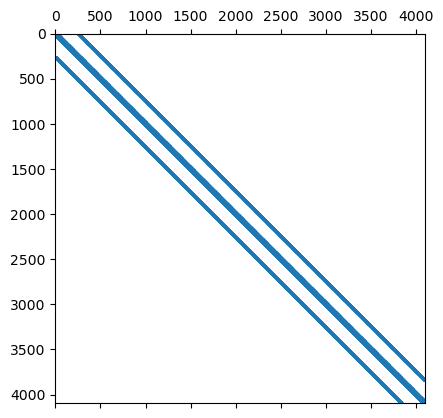

In [28]:
plt.spy(matrix, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją i permutacją")
plt.show()

0.001209855079650879


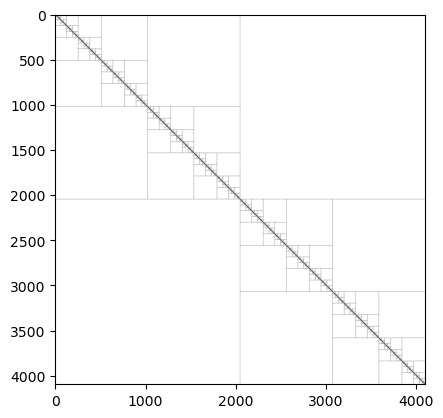

In [29]:
n = len(matrix)
U, s, V = np.linalg.svd(matrix)

print(meassure_compression(matrix, tree))

tree = create_tree(matrix, 2, s[len(s) // 2])
wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości przed permutacją po kompresji")

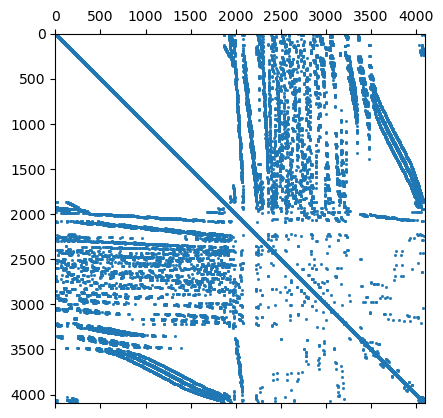

In [30]:
p_table = minimum_degree(matrix)
permutate_matrix_md = permutate(matrix, p_table)
plt.spy(permutate_matrix_md, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"minimum degree\"")
plt.show()

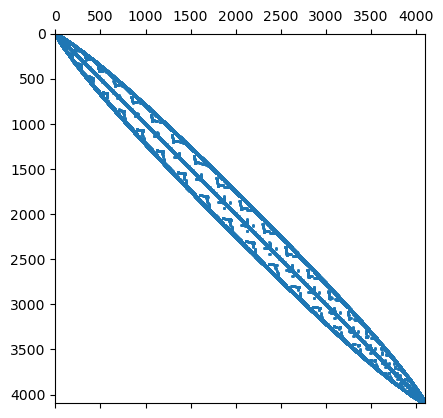

In [31]:
p_table = cuthill_mckee(matrix)
permutate_matrix_cmk = permutate(matrix, p_table)

plt.spy(permutate_matrix_cmk, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"Cuthill-McKee\"")
plt.show()

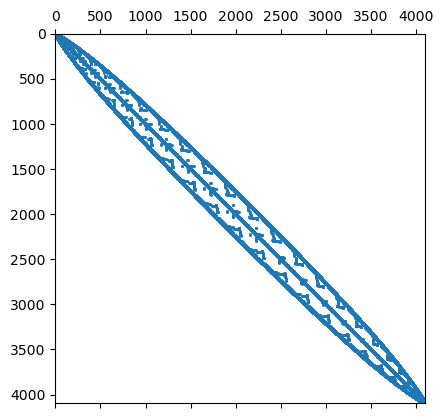

In [32]:
p_table = reversed_cuthill_mckee(matrix)
permutate_matrix_rcmk = permutate(matrix, p_table)

plt.spy(permutate_matrix_rcmk, markersize=1)
# plt.title("Wzorzec rzadkości przed kompresją po permutacji \"reversed Cuthill-McKee\"")
plt.show()

0.029472827911376953


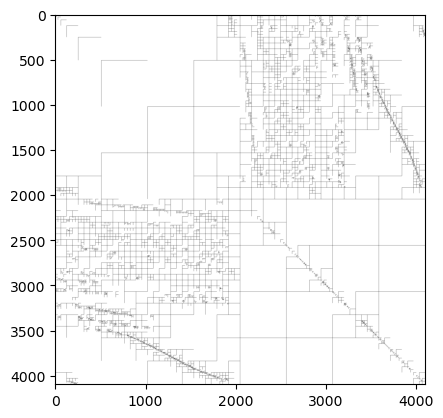

In [33]:
n = len(matrix)
tree = create_tree(permutate_matrix_md, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))


wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"minimum degree\" i po kompresji")
plt.show()

0.01152181625366211


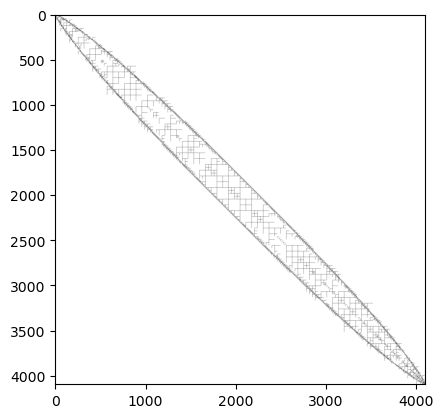

In [34]:
n = len(matrix)
tree = create_tree(permutate_matrix_cmk, 2, s[len(s) // 2])


wisualize_svd(tree, n)

print(meassure_compression(matrix, tree))
# plt.title("Wzorzec rzadkości po permutacji \"Cuthill-McKee\" i po kompresji")
plt.show()

0.01152181625366211


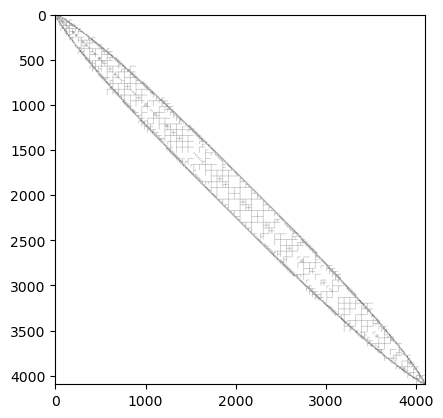

In [35]:
n = len(matrix)
tree = create_tree(permutate_matrix_rcmk, 2, s[len(s) // 2])

print(meassure_compression(matrix, tree))

wisualize_svd(tree, n)
# plt.title("Wzorzec rzadkości po permutacji \"reversed Cuthill-McKee\" i po kompresji")
plt.show()